# ARCH: Autoregressive Conditional Heteroscedasticity

## Volatilidad 

- Buscar estabilidad de la serie a largo plazo.
- Nos interesa la magnitud de los resiudos $\epsilon_t$
- Menor varianza de los datos implica menor volatilidad. Eso se traduce en menor riesgo y mayor seguridad en las inversiones.
- Tomar $\epsilon_{t}^2$ resuelve el problema de signos positivos y negativos.
- $\epsilon_{t}^2$ penaliza diferencias altas entre valores altos y predicciones.

Consiste en dos ecuaciones: basado en la $\mu$ (media) y en la $\sigma^2$
 - Medición de cambios inesperados.

## ARCH

Dos componentes en el modelo: 
i. Heterocedasticidad: dispersión diferente (medidas de dispersión dcomo $\sigma$ y $\sigma^2$. El énfasis es en esta última)

ii. Condicional: un valor que depende de otro, i.e. $P(A|B)$.

El modelo autorregresivo tomando los dos componentes mencionados:
- $(\sigma_{t}^2|x_1\ x_2\ x_3\ ... x_n)$

- $(\sigma_{t}^2|\sigma_1\sigma_2\sigma_3\ ... \sigma_n)$

### ARCH(1)

- $Var(x_t|x_{t-1}) = \alpha_0 + \alpha_1 \epsilon_{t-1}^2$
- $\sigma_{t}^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2$

### ARCH(q)

- $\sigma_{t}^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + ... +\alpha_q \epsilon_{t-q}^2$



## Importing relevant  packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

## Importing Data and Pre-processing

In [10]:
raw_csv_data = pd.read_csv("../../DataSets/Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [11]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [72]:
#df_comp.shape

(6269, 4)

In [4]:
#df_comp = df_comp.asfreq('b')

In [5]:
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [6]:
#df_comp = df_comp.fillna(method = 'ffill')
#df_comp.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [12]:
# Creamos una nueva variabale (una copia de ftse)

df_comp['market_value'] = df_comp.ftse
df_comp.head()

,spx,dax,ftse,nikkei,market_value
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,3445.98
1994-01-10,475.27,2225.00,3440.58,18443.44,3440.58
1994-01-11,474.13,2228.10,3413.77,18485.25,3413.77
1994-01-12,474.17,2182.06,3372.02,18793.88,3372.02
1994-01-13,472.47,2142.37,3360.01,18577.26,3360.01


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

In [15]:
# splitting data set
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### LLR TEST

In [10]:
def LLR_test(mod_1,mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p  = chi2.sf(LR, DF).round(3)
    return p

## Creating Return from 'ftse' values

In [16]:
df['returns'] = df.market_value.pct_change(1)*100
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


In [17]:
df['sq_returns'] = df.returns.mul(df.returns)
df.head()

,market_value,returns,sq_returns
date,,,
1994-01-07,3445.98,NaN,NaN
1994-01-10,3440.58,-0.156704,0.024556
1994-01-11,3413.77,-0.779229,0.607198
1994-01-12,3372.02,-1.222988,1.495700
1994-01-13,3360.01,-0.356166,0.126854


## Returns vs Squared Returns

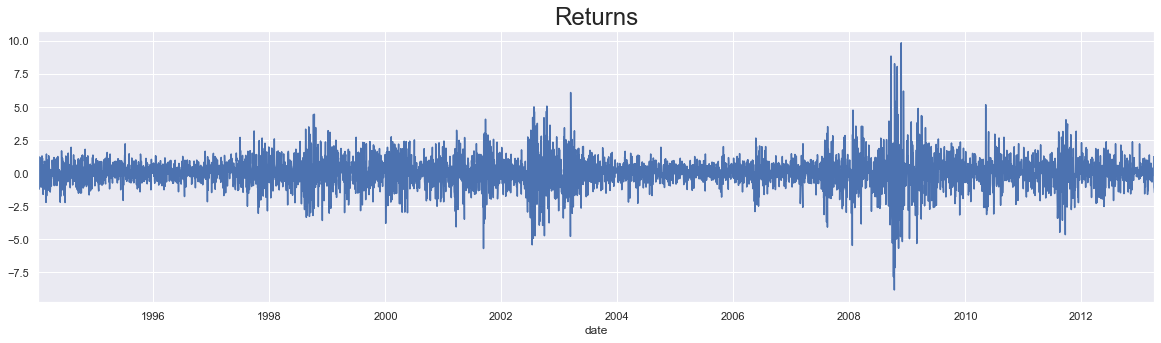

In [18]:
df.returns.plot(figsize =(20,5))
plt.title("Returns", size = 24)
plt.show()

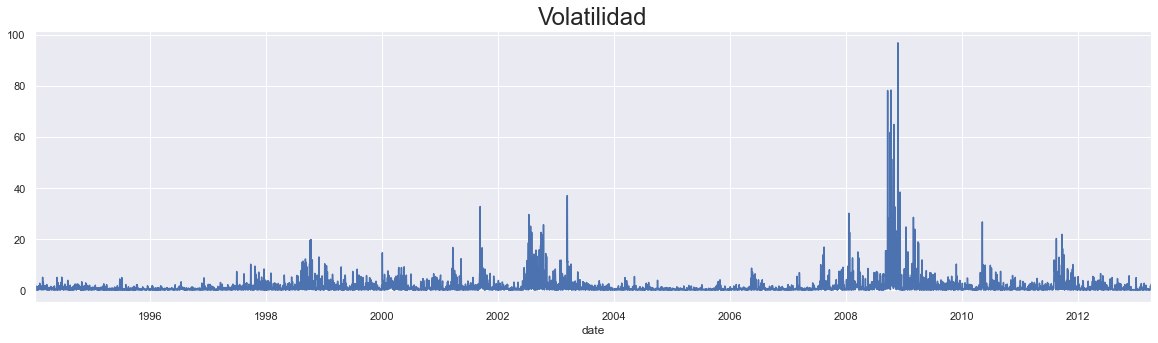

In [19]:
df.sq_returns.plot(figsize =(20,5))
plt.title("Volatilidad", size = 24)
plt.show()

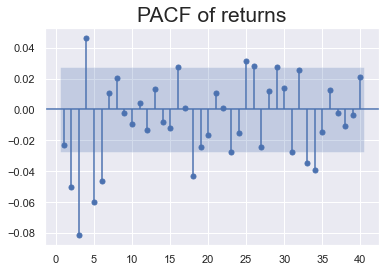

In [21]:
# Mirar plot con función de autocorrelación parcial de los retornos y retornos al cuadrado
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF of returns", size = 21)
plt.show()

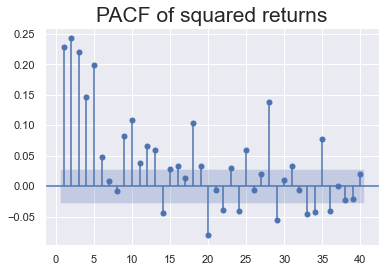

In [22]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF of squared returns", size = 21)
plt.show()

# tiende a existir tendencias a corto plazo en la varianza

## ARCH

In [23]:
!pip install arch

In [24]:
from arch import arch_model

In [25]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit()
# results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6579303469.390623
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2701100877.2298183
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.030632045198
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.035835212278
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418108744094
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.271338807877
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879266228052
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.088048943886
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.0583674757745
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189882
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189167
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Wed, Mar 30 2022   Df Residuals:                     5019
Time:                        13:29:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

# ARCH(1)

In [26]:

model_arch_1 = arch_model(df.returns[1:], mean = 'Constant', vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 1)
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29071.83486537579
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12040.736044828116
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7809.7227529035545
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7660.088789376123
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7660.088782040906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Wed, Mar 30 2022   Df Residuals:                     5019
Time:                        13:36:02   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""